In [28]:
import sys
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import transformers
import matplotlib.pyplot as plt

from time import time
from typing import Optional
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM, PhiForCausalLM
from transformers.models.gpt2.modeling_gpt2 import GPT2LMHeadModel

# GPT-2 Large

In [2]:
# gpt2 large
gpt_tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2-large")
gpt = GPT2LMHeadModel.from_pretrained("openai-community/gpt2-large")

In [3]:
gpt_tokenizer.padding_side = "right"
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token

In [4]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    # https://developer.apple.com/metal/pytorch/
    device = torch.device('mps')
device

device(type='cuda')

In [6]:
gpt = gpt.to(device)

# Data preparation

In [7]:
def create_prompt_func(prompt):
    assert "<word1>" in prompt, "Prompt must include <word1>"
    assert prompt.endswith(" <word2>"), "Prompt must end with \" <word2>\""
    def prompt_func(row):
        word1, word2 = row['word1'], row['word2']
        if type(word1) != str:
            print(word1, row)
        x = prompt.removesuffix(" <word2>").replace("<word1>", word1)
        y = prompt.replace("<word1>", word1).replace("<word2>", word2)
        return x, y
    return prompt_func

def tokenize_and_mask(tokenizer):
    def f(row):
        pre = tokenizer(row[0])
        full = tokenizer(row[1])
        n_prefix = len(pre['input_ids'])
        n_predict = len(full['input_ids']) - n_prefix
        return row[1], n_prefix-1, n_predict
    return f

In [9]:
prompt = "Here are two antonyms <word1> and <word2>"
# keep_default_na=False, we have the word "null", don't want it to be treated as na_value
eacl_df = pd.read_csv('./data/eacl_antonyms.csv', keep_default_na=False, dtype=str)
eacl_df = eacl_df.apply(create_prompt_func(prompt), axis=1, result_type='expand')\
    .apply(tokenize_and_mask(gpt_tokenizer), axis=1, result_type='expand')\
    .rename(columns={0: "text", 1: "loss_mask_idx", 2: "n_predict"})
eacl_df.head()

,text,loss_mask_idx,n_predict
0,Here are two antonyms act and refrain,8,1
1,Here are two antonyms discontinue and keep,9,1
2,Here are two antonyms loosen and tighten,8,1
3,Here are two antonyms tender and demand,8,1
4,Here are two antonyms leave and come,8,1


In [10]:
class AntonymDataset(Dataset):
    def __init__(self, df):
        super(AntonymDataset).__init__()
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text, loss_mask_idx, n_predict = self.df.iloc[idx]
        return text, loss_mask_idx, n_predict

# Wrapped model (GPT-2 Large)

In [11]:
class GPT2PromptModel(torch.nn.Module):
    gpt2: GPT2LMHeadModel
    prompt: torch.Tensor
    prompt_len: int
    
    def __init__(self, prompt_len: int, gpt2):
        super(GPT2PromptModel, self).__init__()
        self.gpt2 = gpt2
        # freeze gpt2 parameters
        for parameter in self.gpt2.parameters():
            parameter.requires_grad = False
        # tunable prompt
        embed_dim = self.gpt2.transformer.embed_dim
        embed_weight = self.gpt2.get_input_embeddings().weight
        self.prompt = torch.nn.Parameter(torch.normal(
            embed_weight.mean(axis=0).broadcast_to(prompt_len, embed_dim),
            embed_weight.std(axis=0).broadcast_to(prompt_len, embed_dim)
        ))
        self.prompt_len = prompt_len

    def forward(
        self,
        prompt_index: int,
        input_ids: Optional[torch.LongTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        **kwargs
    ):
        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            wte = self.gpt2.get_input_embeddings()
            inputs_embeds = wte(input_ids)
        elif inputs_embeds is None:
            raise ValueError("You have to specify either input_ids or inputs_embeds")
        # Insert tunable prompt
        batch_sz = inputs_embeds.shape[0]
        inputs_embeds[:,prompt_index:prompt_index + self.prompt_len,:] = self.prompt.broadcast_to((batch_sz,) + self.prompt.shape)
        return self.gpt2(inputs_embeds=inputs_embeds, **kwargs)

# Training

In [197]:
def train_epoch(prompt_model, train_loader, tokenizer, optimizer, prompt_idx=3):
    prompt_model.eval() # we don't want dropout in the model to activate
    losses = []
    for texts, loss_mask_idxs, n_predicts in train_loader:
        optimizer.zero_grad()
        tokenized = tokenizer(texts, padding=True, return_tensors='pt').to(device)
        batch_sz, seq_len = tokenized['input_ids'].shape
        loss_mask = torch.zeros(batch_sz, seq_len-1)
        for i, (start, n) in enumerate(zip(loss_mask_idxs, n_predicts)):
            loss_mask[i, start:start+n] = 1
        loss_mask = loss_mask.to(device)
        y = tokenized['input_ids'][:, 1:].reshape(-1) # [1:] we don't predict first token
        with torch.autocast("cuda", dtype=torch.bfloat16):
            model_out = prompt_model(prompt_idx, **tokenized)
            y_pred_logits = model_out['logits']
            # Ignore last token predicted
            y_pred_logits = y_pred_logits[:, :-1, :]
            # Merge batch and sequence dimensions for cross entropy loss
            y_pred_logits = y_pred_logits.reshape(-1, y_pred_logits.shape[-1])
            loss_matrix = nn.functional.cross_entropy(y_pred_logits, y, reduction='none').reshape(batch_sz, -1)
            loss = (loss_matrix * loss_mask).sum() / loss_mask.sum()
            loss.backward()
        losses.append(loss.detach())
        optimizer.step()
        # sys.stdout.write('.')
    return sum(losses) / len(losses)

def test_model(prompt_model, test_loader, tokenizer, prompt_idx=3):
    prompt_model.eval()
    losses = []
    with torch.no_grad():
        for texts, loss_mask_idxs, n_predicts in test_loader:
            tokenized = tokenizer(texts, padding=True, return_tensors='pt').to(device)
            batch_sz, seq_len = tokenized['input_ids'].shape
            loss_mask = torch.zeros(batch_sz, seq_len-1)
            for i, (start, n) in enumerate(zip(loss_mask_idxs, n_predicts)):
                loss_mask[i, start:start+n] = 1
            loss_mask = loss_mask.to(device)
            y = tokenized['input_ids'][:, 1:].reshape(-1) # [1:] we don't predict first token
            with torch.autocast("cuda", dtype=torch.bfloat16):
                model_out = prompt_model(prompt_idx, **tokenized)
                y_pred_logits = model_out['logits']
                # Ignore last token predicted
                y_pred_logits = y_pred_logits[:, :-1, :]
                # Merge batch and sequence dimensions for cross entropy loss
                y_pred_logits = y_pred_logits.reshape(-1, y_pred_logits.shape[-1])
                loss_matrix = nn.functional.cross_entropy(y_pred_logits, y, reduction='none').reshape(batch_sz, -1)
                loss = (loss_matrix * loss_mask).sum() / loss_mask.sum()
            losses.append(loss.detach())
    return sum(losses) / len(losses)

# Benchmark

In [37]:
class Wrapper(torch.nn.Module):
    gpt2: GPT2LMHeadModel
    
    def __init__(self, gpt2):
        super().__init__()
        self.gpt2 = gpt2

    def forward(self, _, **kwargs):
        return self.gpt2(**kwargs)

test_model(Wrapper(gpt), test_loader, gpt_tokenizer)

tensor(4.4749, device='cuda:0')

# Training (GPT-2 Large)

In [17]:
seed = 1337
np.random.seed(seed)

In [18]:
train = eacl_df.sample(frac=0.8)
test = eacl_df.drop(train.index)

In [19]:
train_dataset = AntonymDataset(train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = AntonymDataset(test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [22]:
gpt_prompt_model = GPT2PromptModel(len(gpt_tokenizer(" antonyms")['input_ids']), gpt)
gpt_prompt_model = gpt_prompt_model.to(device)

In [23]:
gpt_optimizer = torch.optim.Adam(list(filter(lambda x : x.requires_grad, gpt_prompt_model.parameters())), lr=1e-3)

In [20]:
%%time
test_model(gpt_prompt_model, test_loader, gpt_tokenizer)

CPU times: user 15.9 s, sys: 88.1 ms, total: 16 s
Wall time: 17.2 s


tensor(5.1852, device='cuda:0')

In [21]:
%%time
train_epoch(gpt_prompt_model, train_loader, gpt_tokenizer, gpt_optimizer)

CPU times: user 1min 29s, sys: 43.8 s, total: 2min 12s
Wall time: 2min 13s


tensor(3.7734, device='cuda:0')

In [25]:
train_losses = [test_model(gpt_prompt_model, train_loader, gpt_tokenizer)]
test_losses = [test_model(gpt_prompt_model, test_loader, gpt_tokenizer)]

In [26]:
epoch_id = int(time())
for epoch in range(100):
    train_loss = train_epoch(gpt_prompt_model, train_loader, gpt_tokenizer, gpt_optimizer).item()
    test_loss = test_model(gpt_prompt_model, test_loader, gpt_tokenizer).item()
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(epoch, train_loss, test_loss)
    if epoch % 5 == 4:
        torch.save(gpt_prompt_model.prompt, f'{epoch_id}-epoch{epoch}-prompt.pt')

0 3.7490639686584473 3.4102284908294678
1 3.3546550273895264 3.32865309715271
2 3.291999340057373 3.28523325920105
3 3.259598731994629 3.2900350093841553
4 3.2261672019958496 3.2820823192596436
5 3.205158233642578 3.2402915954589844
6 3.201430559158325 3.2400643825531006
7 3.183424472808838 3.2532167434692383
8 3.1996400356292725 3.2230072021484375
9 3.1939945220947266 3.2651209831237793
10 3.1960291862487793 3.235297203063965
11 3.171877145767212 3.2453551292419434
12 3.184633493423462 3.207913398742676
13 3.157175064086914 3.205815315246582
14 3.1203858852386475 3.2204930782318115
15 3.1327123641967773 3.196530342102051
16 3.126887083053589 3.1894307136535645
17 3.127190113067627 3.188394546508789
18 3.1394636631011963 3.187258720397949
19 3.1213724613189697 3.185823440551758
20 3.1144518852233887 3.196652412414551
21 3.1159753799438477 3.182175636291504
22 3.106828212738037 3.1740312576293945
23 3.125544786453247 3.1753787994384766
24 3.0894830226898193 3.170797348022461
25 3.097318

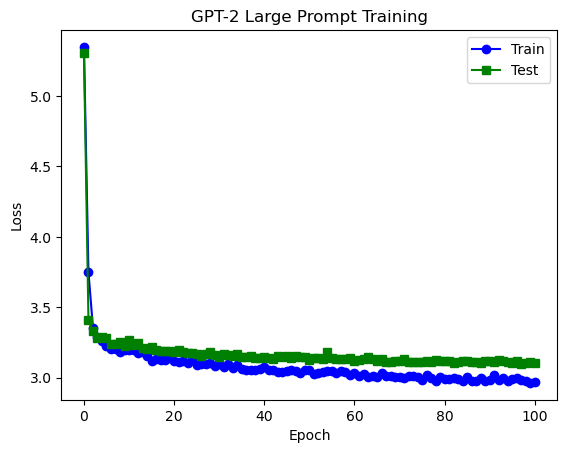

In [35]:
gpt_train_losses = train_losses
gpt_test_losses = test_losses
x = range(100+1)
plt.figure()
plt.plot(x, gpt_train_losses, label='Train', color='blue', marker='o')
plt.plot(x, gpt_test_losses, label='Test', color='green', marker='s')
plt.title('GPT-2 Large Prompt Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Results (GPT-2 Large)

In [91]:
with torch.no_grad():
    for i, sample in test.sample(n=20).iterrows():
        text, loss_mask_idx, n_predict = sample['text'], sample['loss_mask_idx'], sample['n_predict']
        tokens = gpt_tokenizer(sample['text'], return_tensors='pt').to(device)
        input_ids = tokens['input_ids']
        toks = []
        for j in range(n_predict):
            if toks:
                inp = torch.concat((input_ids[:,:loss_mask_idx+1], torch.LongTensor(toks).reshape(1,len(toks)).to(device)), dim=-1)
            else:
                inp = input_ids[:,:loss_mask_idx+1]
            output = gpt_prompt_model(3, input_ids = inp)
            tok = output.logits[0][-1].argmax()
            toks.append(tok)

        pred = gpt_tokenizer.decode(input_ids[0][:loss_mask_idx+1].tolist() + toks).replace('antonyms', '<prompt>')
        print(f'Actual: {text}')
        print(f'Predicted: {pred}')
        print()

Actual: Here are two antonyms scatter and crowd
Predicted: Here are two <prompt> scatter and gather

Actual: Here are two antonyms flat and uneven
Predicted: Here are two <prompt> flat and curved

Actual: Here are two antonyms unpack and pack
Predicted: Here are two <prompt> unpack and pack

Actual: Here are two antonyms extinct and active
Predicted: Here are two <prompt> extinct and extant

Actual: Here are two antonyms mind and forget
Predicted: Here are two <prompt> mind and body

Actual: Here are two antonyms disarm and arm
Predicted: Here are two <prompt> disarm and disarm

Actual: Here are two antonyms glabrous and haired
Predicted: Here are two <prompt> glabrous and smooth;

Actual: Here are two antonyms concerned and unconcerned
Predicted: Here are two <prompt> concerned and uninvolved

Actual: Here are two antonyms interesting and uninteresting
Predicted: Here are two <prompt> interesting and uninteresting

Actual: Here are two antonyms ordinal and cardinal
Predicted: Here are

## Prompt interpretability

In [40]:
gpt.transformer.wte

Embedding(50257, 1280)

In [42]:
prompt_emb = gpt_prompt_model.prompt.detach()
wte = gpt.transformer.wte.weight.detach()
for i in range(prompt_emb.shape[0]):
    closest = nn.functional.cosine_similarity(wte, prompt_emb[i:i+1,:], dim=1).argmax().item()
    best = nn.functional.cosine_similarity(wte, prompt_emb[i:i+1,:], dim=1).max().item()
    print(f'token_id: {closest}, token: "{gpt_tokenizer.decode(closest)}", cosine similarity: {best}')

token_id: 39686, token: "sounding", cosine similarity: 0.22011171281337738
token_id: 30439, token: " unintention", cosine similarity: 0.21060492098331451
token_id: 9364, token: "ÃÂÃÂÃÂÃÂ", cosine similarity: 0.19043108820915222
token_id: 14606, token: " aest", cosine similarity: 0.147452250123024


# Optimisation

In [ ]:
gpt_flash = GPT2LMHeadModel.from_pretrained("openai-community/gpt2-large", torch_dtype=torch.bfloat16, attn_implementation="flash_attention_2")
gpt_flash = gpt_flash.to(device)

In [97]:
xx_model = GPT2PromptModel(len(gpt_tokenizer(" antonyms")['input_ids']), gpt)
xx_model = xx_model.to(device)

In [98]:
xx_optimizer = torch.optim.Adam(list(filter(lambda x : x.requires_grad, xx_model.parameters())), lr=1e-3)

In [99]:
%%time
train_epoch(xx_model, train_loader, gpt_tokenizer, xx_optimizer)

CPU times: user 22.7 s, sys: 13.3 s, total: 36 s
Wall time: 36.9 s


tensor(3.7938, device='cuda:0')

In [104]:
yy_model = GPT2PromptModel(len(gpt_tokenizer(" antonyms")['input_ids']), gpt_flash)
yy_model = yy_model.to(device)

In [105]:
yy_optimizer = torch.optim.Adam(list(filter(lambda x : x.requires_grad, yy_model.parameters())), lr=1e-3)

In [108]:
%%time
train_epoch(yy_model, train_loader, gpt_tokenizer, yy_optimizer)

CPU times: user 30.7 s, sys: 5.99 s, total: 36.7 s
Wall time: 36.6 s


tensor(3.4163, device='cuda:0')

# Strict vocabulary

In [168]:
class GPT2VocabPromptModel(torch.nn.Module):
    gpt2: GPT2LMHeadModel
    prompt: torch.Tensor
    prompt_len: int
    
    def __init__(self, prompt_len: int, gpt2):
        super(GPT2VocabPromptModel, self).__init__()
        self.gpt2 = gpt2
        # freeze gpt2 parameters
        for parameter in self.gpt2.parameters():
            parameter.requires_grad = False
        # tunable prompt
        wte = self.gpt2.get_input_embeddings().weight
        vocab_sz, _ = wte.shape
        self.prompt = torch.nn.Parameter(torch.normal(
            torch.zeros(prompt_len, vocab_sz),
            torch.ones(prompt_len, vocab_sz) * 6
        ))
        self.prompt_len = prompt_len

    def forward(
        self,
        prompt_index: int,
        input_ids: Optional[torch.LongTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        **kwargs
    ):
        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            wte = self.gpt2.get_input_embeddings()
            inputs_embeds = wte(input_ids)
        elif inputs_embeds is None:
            raise ValueError("You have to specify either input_ids or inputs_embeds")
        # Insert tunable prompt
        batch_sz = inputs_embeds.shape[0]
        wte_matrix = self.gpt2.get_input_embeddings().weight
        prompt_embed = torch.softmax(self.prompt, axis=1) @ wte_matrix
        inputs_embeds[:,prompt_index:prompt_index + self.prompt_len,:] = prompt_embed.broadcast_to((batch_sz,) + prompt_embed.shape)
        return self.gpt2(inputs_embeds=inputs_embeds, **kwargs)

In [169]:
gpt_vocab_model = GPT2VocabPromptModel(len(gpt_tokenizer(" antonyms")['input_ids']), gpt)
gpt_vocab_model = gpt_vocab_model.to(device)

In [170]:
gpt_vocab_optimizer = torch.optim.Adam(list(filter(lambda x : x.requires_grad, gpt_vocab_model.parameters())), lr=1e-3)

In [173]:
%%time
train_epoch(gpt_vocab_model, train_loader, gpt_tokenizer, gpt_vocab_optimizer)

CPU times: user 22.4 s, sys: 14.1 s, total: 36.4 s
Wall time: 36.3 s


tensor(5.6745, device='cuda:0')

In [175]:
gpt_vocab_model.prompt.softmax(axis=-1).max(axis=-1)

torch.return_types.max(
values=tensor([0.7409, 0.0811, 0.9591, 0.3122], device='cuda:0',
       grad_fn=<MaxBackward0>),
indices=tensor([30223,  8506, 49760, 26177], device='cuda:0'))

# Sample efficiency

In [185]:
gpt_100_model = GPT2PromptModel(len(gpt_tokenizer(" antonyms")['input_ids']), gpt)
gpt_100_model = gpt_100_model.to(device)

In [186]:
gpt_100_optimizer = torch.optim.Adam(list(filter(lambda x : x.requires_grad, gpt_100_model.parameters())), lr=1e-3)

In [187]:
train_100 = eacl_df.sample(n=100)
test_100 = eacl_df.drop(train_100.index)
train_100_dataset = AntonymDataset(train_100)
train_100_loader = DataLoader(train_100_dataset, batch_size=64, shuffle=True)
test_100_dataset = AntonymDataset(test_100)
test_100_loader = DataLoader(test_100_dataset, batch_size=64, shuffle=False)

In [188]:
train_100_losses = [test_model(gpt_100_model, train_100_loader, gpt_tokenizer)]
test_100_losses = [test_model(gpt_100_model, test_100_loader, gpt_tokenizer)]

In [189]:
for epoch in range(30):
    train_loss = train_epoch(gpt_100_model, train_100_loader, gpt_tokenizer, gpt_100_optimizer).item()
    test_loss = test_model(gpt_100_model, test_100_loader, gpt_tokenizer).item()
    train_100_losses.append(train_loss)
    test_100_losses.append(test_loss)
    print(epoch, train_loss, test_loss)

0 4.9206647872924805 4.723216533660889
1 4.518998622894287 4.414457321166992
2 4.176107406616211 4.253404140472412
3 4.143115997314453 4.175540924072266
4 3.9737844467163086 4.080785751342773
5 3.9014878273010254 3.992617130279541
6 3.788574695587158 3.9271490573883057
7 3.7430598735809326 3.8675918579101562
8 3.756380081176758 3.8101699352264404
9 3.8115458488464355 3.760075092315674
10 3.428203582763672 3.7204530239105225
11 3.505437135696411 3.6871120929718018
12 3.3675222396850586 3.669783115386963
13 3.4548778533935547 3.659501314163208
14 3.5060386657714844 3.65264630317688
15 3.322779655456543 3.6544158458709717
16 3.4423203468322754 3.6494057178497314
17 3.2354629039764404 3.6389002799987793
18 3.0651397705078125 3.624098062515259
19 3.228386878967285 3.6068177223205566
20 3.242203712463379 3.598388433456421
21 3.2477545738220215 3.600524663925171
22 3.2736830711364746 3.5952343940734863
23 3.1961867809295654 3.577242851257324
24 3.0769762992858887 3.5613958835601807
25 3.09490

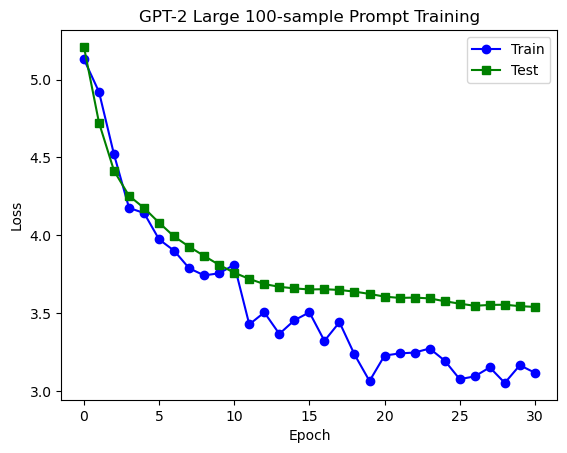

In [194]:
gpt_train_losses = train_100_losses
gpt_test_losses = test_100_losses
x = range(30+1)
plt.figure()
plt.plot(x, gpt_train_losses, label='Train', color='blue', marker='o')
plt.plot(x, gpt_test_losses, label='Test', color='green', marker='s')
plt.title('GPT-2 Large 100-sample Prompt Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [195]:
with torch.no_grad():
    for i, sample in test_100.sample(n=20).iterrows():
        text, loss_mask_idx, n_predict = sample['text'], sample['loss_mask_idx'], sample['n_predict']
        tokens = gpt_tokenizer(sample['text'], return_tensors='pt').to(device)
        input_ids = tokens['input_ids']
        toks = []
        for j in range(n_predict):
            if toks:
                inp = torch.concat((input_ids[:,:loss_mask_idx+1], torch.LongTensor(toks).reshape(1,len(toks)).to(device)), dim=-1)
            else:
                inp = input_ids[:,:loss_mask_idx+1]
            output = gpt_100_model(3, input_ids = inp)
            tok = output.logits[0][-1].argmax()
            toks.append(tok)

        pred = gpt_tokenizer.decode(input_ids[0][:loss_mask_idx+1].tolist() + toks).replace('antonyms', '<prompt>')
        print(f'Actual: {text}')
        print(f'Predicted: {pred}')
        print()

Actual: Here are two antonyms knockout and decision
Predicted: Here are two <prompt> knockout and knockout

Actual: Here are two antonyms heterogeneity and homogeneity
Predicted: Here are two <prompt> heterogeneity and uniformity

Actual: Here are two antonyms widening and narrowing
Predicted: Here are two <prompt> widening and narrowing

Actual: Here are two antonyms incapable and capable
Predicted: Here are two <prompt> incapable and capable

Actual: Here are two antonyms refreshing and old
Predicted: Here are two <prompt> refreshing and depressing

Actual: Here are two antonyms shy and bold
Predicted: Here are two <prompt> shy and bold

Actual: Here are two antonyms plain and decorated
Predicted: Here are two <prompt> plain and complex

Actual: Here are two antonyms end and start
Predicted: Here are two <prompt> end and beginning

Actual: Here are two antonyms imperfect and perfect
Predicted: Here are two <prompt> imperfect and perfect

Actual: Here are two antonyms white and colour